# **Classify Waste Products Using Transfer Learning with VGG16**

In this project, I will use transfer learning with a pre-trained VGG16 model to classify images of waste products into recyclable and organic categories. The goal is to develop an automated system that can accurately differentiate between types of waste to improve sorting efficiency and reduce contamination.

Working in collaboration with EcoClean, a company aiming to automate its waste sorting process, this project addresses the challenges of manual sorting, which is labor-intensive and prone to errors.

By fine-tuning the VGG16 model on a dataset of waste images, I will train and evaluate a classifier that can be applied in real-world waste management to boost automation and environmental sustainability.

This project will help me build practical skills in computer vision and transfer learning, using a powerful pre-trained convolutional neural network to solve an important environmental problem.

## Setup

For this lab, you will be using the following libraries:

- `numpy` for mathematical operations.
- `sklearn` for machine learning and machine-learning-pipeline related functions.
- `matplotlib` for additional plotting tools.
- `tensorflow` for machine learning and neural network related functions.

Installing Required Libraries

In [ ]:
!pip install tensorflow==2.17.0 | tail -n 1
!pip install numpy==1.24.3 | tail -n 1
!pip install scikit-learn==1.5.1  | tail -n 1
!pip install matplotlib==3.9.2  | tail -n 1

Importing Required Libraries

In [1]:
import numpy as np
import os
# import random, shutil
import glob


from matplotlib import pyplot as plt
from matplotlib import pyplot
from matplotlib.image import imread

# from os import makedirs,listdir
# from shutil import copyfile
# from random import seed
# from random import random

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D, Input
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.applications import InceptionV3
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

## Create a model for distinguishing **Recyclable** and **Organic** Waste Images

### **Dataset**

You will be using the [Waste Classification Dataset](https://www.kaggle.com/datasets/techsash/waste-classification-data).

Your goal is to train an algorithm on these images and to predict the labels for images in your test set (1 = recyclable, 0 = organic).

### **Importing Data**

This will create a `o-vs-r-split` directory in your environment.

In [2]:
import requests
import zipfile
from tqdm import tqdm

url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/kd6057VPpABQ2FqCbgu9YQ/o-vs-r-split-reduced-1200.zip"
file_name = "o-vs-r-split-reduced-1200.zip"

print("Downloading file")
with requests.get(url, stream=True) as response:
    response.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)


def extract_file_with_progress(file_name):
    print("Extracting file with progress")
    with zipfile.ZipFile(file_name, 'r') as zip_ref:
        members = zip_ref.infolist()
        with tqdm(total=len(members), unit='file') as progress_bar:
            for member in members:
                zip_ref.extract(member)
                progress_bar.update(1)
    print("Finished extracting file")


extract_file_with_progress(file_name)

print("Finished extracting file")
os.remove(file_name)

Extracting file with progress


100%|██████████| 1207/1207 [00:00<00:00, 5714.49file/s]

Finished extracting file
Finished extracting file


## Define **Configuration** Options!
It's time to define some model configuration options.

**batch size** is set to 32.
The number of **classes** is 2.
You will use 20% of the data for **validation** purposes.
You have two **labels** in your dataset: organic (O), recyclable (R).

In [3]:
img_rows, img_cols = 150, 150
batch_size = 32
n_epochs = 10
n_classes = 2
val_split = 0.2
verbosity = 1
path = 'o-vs-r-split/train/'
path_test = 'o-vs-r-split/test/'
input_shape = (img_rows, img_cols, 3)
labels = ['O', 'R']
seed = 42

## Loading Images using `ImageGeneratorClass`

Transfer learning works best when models are trained on smaller datasets.

The folder structure looks as follows:

```python
o-vs-r-split/
└── train
    ├── O
    └── R
└── test
    ├── O
    └── R
```




## `ImageDataGenerators`


Now you will create **ImageDataGenerators** used for training, validation and testing.

Image data generators create **batches** of tensor image data with real-time **Data Augmentation**. The generators **loop** over the data in **batches** and are useful in **feeding** data to the **training** process.

In [4]:
# Create ImageDataGenerators for training and validation and testing

train_datagen = ImageDataGenerator(
    validation_split = val_split,
    rescale=1.0/255.0,
	width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    validation_split = val_split,
    rescale=1.0/255.0,
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

In [5]:
train_generator = train_datagen.flow_from_directory(
    directory = path,
    seed = seed,
    batch_size = batch_size,
    class_mode='binary',
    shuffle = True,
    target_size=(img_rows, img_cols),
    subset = 'training'
)

Found 800 images belonging to 2 classes.


In [6]:
val_generator = val_datagen.flow_from_directory(
    directory = path,
    seed = seed,
    batch_size = batch_size,
    class_mode='binary',
    shuffle = True,
    target_size=(img_rows, img_cols),
    subset = 'validation'
)

Found 200 images belonging to 2 classes.


As observed, the `ImageDataGenerators` successfully created data loaders for training and validation with real-time data augmentation and rescaling. The **training** generator found **800** images across 2 classes, while the **validation** generator found **200** images across the same 2 classes.

Now, create a `test_generator` using the `test_datagen` object

In [7]:
# Create a `test_generator` using the `test_datagen` object

test_generator = test_datagen.flow_from_directory(

    directory=path_test,
    class_mode='binary',
    seed=seed,
    batch_size=batch_size,
    shuffle=False,
    target_size=(img_rows, img_cols)

)

Found 200 images belonging to 2 classes.


In [8]:
# Print the length of the train_generator

print(len(train_generator))

25


As observed, the length of the `train_generator` is 25, meaning the generator will yield 25 batches per epoch during training. This corresponds to the total number of training images divided by the batch size, allowing the model to process the entire training dataset in manageable batches.

Labels: [np.str_('O'), np.str_('O'), np.str_('O'), np.str_('O'), np.str_('O')]


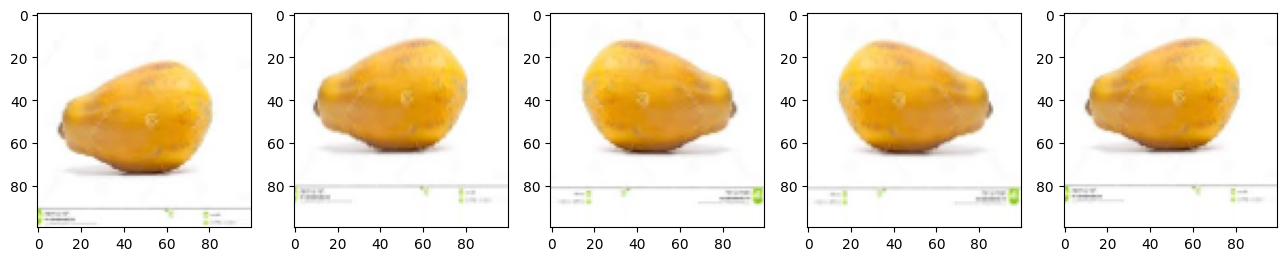

In [9]:
from pathlib import Path

IMG_DIM = (100, 100)

train_files = glob.glob('./o-vs-r-split/train/O/*')
train_files = train_files[:20]
train_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [Path(fn).parent.name for fn in train_files]

img_id = 0
O_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1],
                                   batch_size=1)
O = [next(O_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in O])
l = [ax[i].imshow(O[i][0][0]) for i in range(0,5)]

As observed, the data augmentation pipeline is working correctly.

Each time the same image is passed through the generator, it returns a slightly different version due to real-time transformations like shifting and flipping.

The labels confirm that all these images belong to the 'O' (organic) class, demonstrating that the model will see a variety of augmented samples for each training image, helping it generalize better.

## Pre-trained Models

Pre-trained models are saved networks that have previously been trained on some large datasets. They are typically used for large-scale image-classification task. They can be used as they are or could be customized to a given task using transfer learning. These pre-trained models form the basis of transfer learning.

### `VGG-16`

Let us load the VGG16 model.

In [10]:
from tensorflow.keras.applications import vgg16

input_shape = (150, 150, 3)
vgg = vgg16.VGG16(include_top=False,
                        weights='imagenet',
                        input_shape=input_shape)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


We flatten the output of a vgg model and assign it to the model `output`, we then use a Model object `basemodel` to group the layers into an object for training and inference .
With the following inputs and outputs

inputs: `vgg.input`

outputs: `tf.keras.layers.Flatten()(output)`

In [11]:
output = vgg.layers[-1].output
output = tf.keras.layers.Flatten()(output)
basemodel = Model(vgg.input, output)

Next, you **freeze** the basemodel.

In [12]:
for layer in basemodel.layers:
    layer.trainable = False

Create a new model on top. You add a Dropout layer for regularization, only these layers will change as for the lower layers you set `training=False` when calling the base model.

In [13]:
input_shape = basemodel.output_shape[1]

model = Sequential()
model.add(basemodel)
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

In [14]:
# Print the summary of the model

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional (Functional)         │ (None, 8192)           │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,172,673 (73.14 MB)

 Trainable params: 4,457,985 (17.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

As observed, the constructed sequential model combines the pre-trained base model output (with 8192 features) followed by fully connected layers for classification.
The model includes two dense layers of 512 units each with ReLU activation and dropout for regularization, ending with a single sigmoid unit for binary classification.

The summary indicates a total of approximately 19.17 million parameters, of which about 4.46 million are trainable, and the rest are frozen layers from the pre-trained base model. This setup balances leveraging pre-trained features with learning task-specific patterns for waste classification.

In [15]:
# Freeze the base model layers
for layer in basemodel.layers:
    layer.trainable = False

# Task 5: Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(learning_rate=1e-4),
    metrics=['accuracy']
)

You will use early **stopping** to avoid over-training the model.

In [16]:
from tensorflow.keras.callbacks import LearningRateScheduler


checkpoint_path='O_R_tlearn_vgg16.keras'

# define step decay function
class LossHistory_(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(exp_decay(epoch))
        print('lr:', exp_decay(len(self.losses)))

def exp_decay(epoch):
    initial_lrate = 1e-4
    k = 0.1
    lrate = initial_lrate * np.exp(-k*epoch)
    return lrate

# learning schedule callback
loss_history_ = LossHistory_()
lrate_ = LearningRateScheduler(exp_decay)

keras_callbacks = [
      EarlyStopping(monitor = 'val_loss',
                    patience = 4,
                    mode = 'min',
                    min_delta=0.01),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

callbacks_list_ = [loss_history_, lrate_] + keras_callbacks

In [17]:
# Fit and train the model

extract_feat_model = model.fit(train_generator,
                               steps_per_epoch=5,
                               epochs=10,
                               callbacks = callbacks_list_,
                               validation_data=val_generator,
                               validation_steps=val_generator.samples // batch_size,
                               verbose=1)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4869 - loss: 0.7192lr: 9.048374180359596e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 61s 14s/step - accuracy: 0.4964 - loss: 0.7131 - val_accuracy: 0.6823 - val_loss: 0.5939 - learning_rate: 1.0000e-04
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6907 - loss: 0.5854lr: 8.187307530779819e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 82s 19s/step - accuracy: 0.6881 - loss: 0.5876 - val_accuracy: 0.6615 - val_loss: 0.5772 - learning_rate: 9.0484e-05
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6965 - loss: 0.5492lr: 7.408182206817179e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 62s 14s/step - accuracy: 0.6981 - loss: 0.5499 - val_accuracy: 0.7917 - val_loss: 0.4853 - learning_rate: 8.1873e-05
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7631 - loss: 0.4880lr: 6.703200460356394e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 82s 19s/step - accuracy: 0.7693 - loss: 0.4840 - val_accuracy: 0.8125 - val_loss: 0.4481 - learning_rate: 7.4082e-05
Epoch 5/

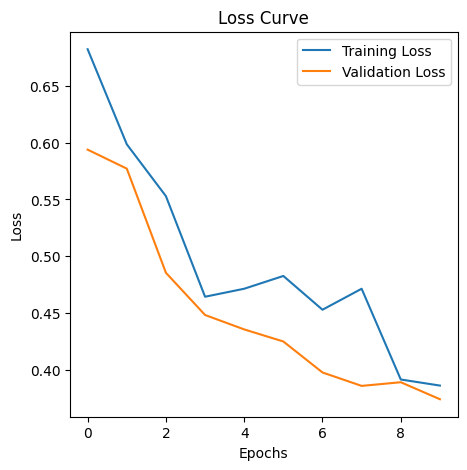

In [18]:
import matplotlib.pyplot as plt

history = extract_feat_model

# plot loss curve
plt.figure(figsize=(5, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

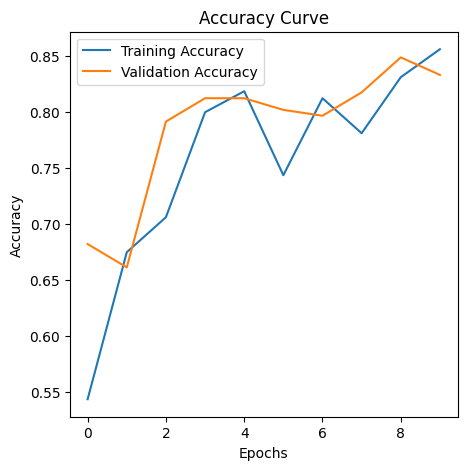

In [19]:
import matplotlib.pyplot as plt

# Task 6: Plot accuracy curves for training and validation sets
fig = plt.figure(figsize=(5, 5))

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [20]:
from tensorflow.keras.applications import vgg16

input_shape = (150, 150, 3)
vgg = vgg16.VGG16(include_top=False,
                        weights='imagenet',
                        input_shape=input_shape)

output = vgg.layers[-1].output
output = tf.keras.layers.Flatten()(output)
basemodel = Model(vgg.input, output)

for layer in basemodel.layers:
    layer.trainable = False

display([layer.name for layer in basemodel.layers])

set_trainable = False

for layer in basemodel.layers:
    if layer.name in ['block5_conv3']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

for layer in basemodel.layers:
    print(f"{layer.name}: {layer.trainable}")

['input_layer_2',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_pool',
 'flatten_1']

input_layer_2: False
block1_conv1: False
block1_conv2: False
block1_pool: False
block2_conv1: False
block2_conv2: False
block2_pool: False
block3_conv1: False
block3_conv2: False
block3_conv3: False
block3_pool: False
block4_conv1: False
block4_conv2: False
block4_conv3: False
block4_pool: False
block5_conv1: False
block5_conv2: False
block5_conv3: True
block5_pool: True
flatten_1: True


In [21]:
model = Sequential()
model.add(basemodel)
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

checkpoint_path='O_R_tlearn_fine_tune_vgg16.keras'

# learning schedule callback
loss_history_ = LossHistory_()
lrate_ = LearningRateScheduler(exp_decay)

keras_callbacks = [
      EarlyStopping(monitor = 'val_loss',
                    patience = 4,
                    mode = 'min',
                    min_delta=0.01),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

callbacks_list_ = [loss_history_, lrate_] + keras_callbacks

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

fine_tune_model = model.fit(train_generator,
                    steps_per_epoch=5,
                    epochs=10,
                    callbacks = callbacks_list_,
                    validation_data=val_generator,
                    validation_steps=val_generator.samples // batch_size,
                    verbose=1)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5456 - loss: 0.6997lr: 9.048374180359596e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 63s 14s/step - accuracy: 0.5526 - loss: 0.6988 - val_accuracy: 0.5521 - val_loss: 0.6751 - learning_rate: 1.0000e-04
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6297 - loss: 0.6639lr: 8.187307530779819e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 82s 19s/step - accuracy: 0.6393 - loss: 0.6546 - val_accuracy: 0.7865 - val_loss: 0.4491 - learning_rate: 9.0484e-05
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7700 - loss: 0.5191lr: 7.408182206817179e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 82s 19s/step - accuracy: 0.7677 - loss: 0.5156 - val_accuracy: 0.8021 - val_loss: 0.4210 - learning_rate: 8.1873e-05
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7441 - loss: 0.5261lr: 6.703200460356394e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 81s 19s/step - accuracy: 0.7492 - loss: 0.5176 - val_accuracy: 0.8073 - val_loss: 0.3953 - learning_rate: 7.4082e-05
Epoch 5/

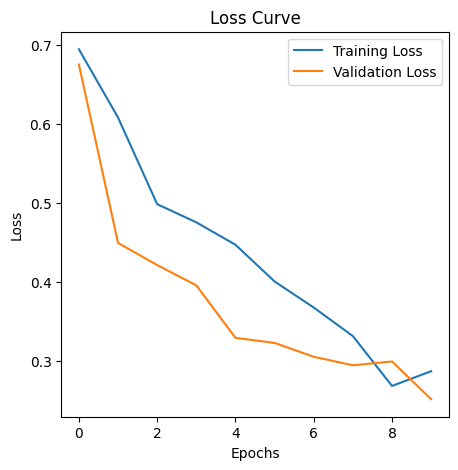

In [22]:
import matplotlib.pyplot as plt

# Assuming fine_tune_model is your trained model and `history` is its history object

history = fine_tune_model

plt.figure(figsize=(5, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('plot_loss_curve.png')
plt.show()

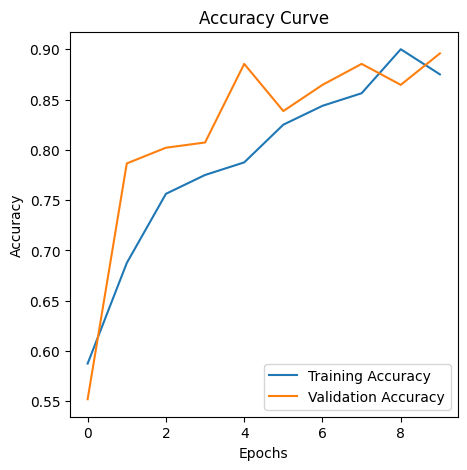

In [23]:
import matplotlib.pyplot as plt

history = fine_tune_model

plt.figure(figsize=(5, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('plot_finetune_model.png')
plt.show()

In [26]:
from pathlib import Path

# Load saved models
extract_feat_model = tf.keras.models.load_model('O_R_tlearn_vgg16.keras')
fine_tune_model = tf.keras.models.load_model('O_R_tlearn_fine_tune_vgg16.keras')

IMG_DIM = (150, 150)

# Load test images
test_files_O = glob.glob('./o-vs-r-split/test/O/*')
test_files_R = glob.glob('./o-vs-r-split/test/R/*')
test_files = test_files_O[:50] + test_files_R[:50]

test_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM)) for img in test_files]
test_imgs = np.array(test_imgs)
test_labels = [Path(fn).parent.name for fn in test_files]

# Standardize
test_imgs_scaled = test_imgs.astype('float32')
test_imgs_scaled /= 255

class2num_lt = lambda l: [0 if x == 'O' else 1 for x in l]
num2class_lt = lambda l: ['O' if x < 0.5 else 'R' for x in l]

test_labels_enc = class2num_lt(test_labels)

# Make predictions for both models
predictions_extract_feat_model = extract_feat_model.predict(test_imgs_scaled, verbose=0)
predictions_fine_tune_model = fine_tune_model.predict(test_imgs_scaled, verbose=0)

# Convert predictions to class labels
predictions_extract_feat_model = num2class_lt(predictions_extract_feat_model)
predictions_fine_tune_model = num2class_lt(predictions_fine_tune_model)

# Print classification report for both models
print('Extract Features Model', "\n")
print(metrics.classification_report(test_labels, predictions_extract_feat_model))
print('Fine-Tuned Model', "\n")
print(metrics.classification_report(test_labels, predictions_fine_tune_model))

Extract Features Model 

              precision    recall  f1-score   support

           O       0.90      0.86      0.88        50
           R       0.87      0.90      0.88        50

    accuracy                           0.88       100
   macro avg       0.88      0.88      0.88       100
weighted avg       0.88      0.88      0.88       100

Fine-Tuned Model 

              precision    recall  f1-score   support

           O       0.86      0.88      0.87        50
           R       0.88      0.86      0.87        50

    accuracy                           0.87       100
   macro avg       0.87      0.87      0.87       100
weighted avg       0.87      0.87      0.87       100



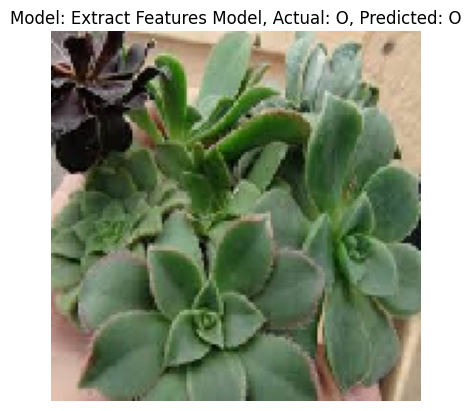

In [27]:
# Plot one of the images with actual label and predicted label as title
def plot_image_with_title(image, model_name, actual_label, predicted_label):
    plt.imshow(image)
    plt.title(f"Model: {model_name}, Actual: {actual_label}, Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()

# Specify index of image to plot, for example index 0
index_to_plot = 0
plot_image_with_title(
    image=test_imgs[index_to_plot].astype('uint8'),
    model_name='Extract Features Model',
    actual_label=test_labels[index_to_plot],
    predicted_label=predictions_extract_feat_model[index_to_plot],
    )

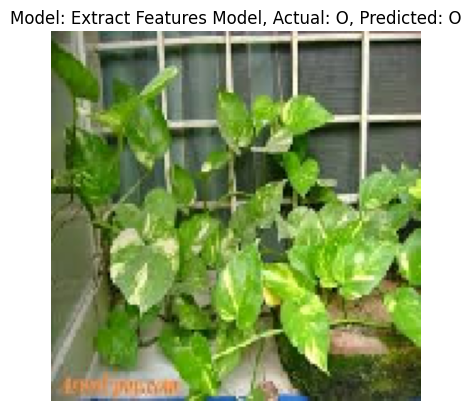

In [30]:
index_to_plot = 1
model_name = 'Extract Features Model'
predicted_label = predictions_extract_feat_model[index_to_plot]

# Define plot_image_with_title function if not already defined

import matplotlib.pyplot as plt

def plot_image_with_title(image, title):
    plt.imshow(image.astype('uint8'))
    plt.title(title)
    plt.axis('off')
    plt.show()

# Plot the image with the predicted label as the title

plot_image_with_title(test_imgs[index_to_plot], f"Model: {model_name}, Actual: {test_labels[index_to_plot]}, Predicted: {predicted_label}")

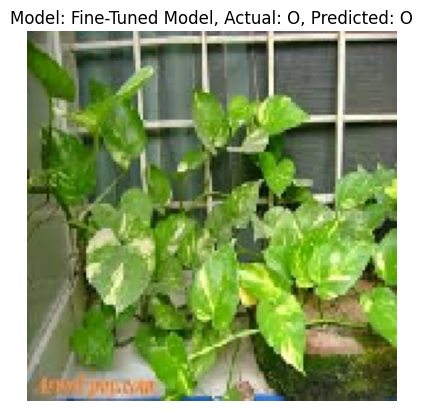

In [31]:
index_to_plot = 1
model_name = 'Fine-Tuned Model'
predicted_label = predictions_fine_tune_model[index_to_plot]

def plot_image_with_title(image, model_name, actual_label, predicted_label):
    plt.imshow(image.astype('uint8'))
    plt.title(f"Model: {model_name}, Actual: {actual_label}, Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()

plot_image_with_title(
    image=test_imgs[index_to_plot],
    model_name=model_name,
    actual_label=test_labels[index_to_plot],
    predicted_label=predicted_label
)